# Importing Libraries

In [72]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

# Reading in the data

In [73]:
data = pd.read_csv('QVI_data.csv')

In [74]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [75]:
data['MONTH_ID'] = data['DATE'].dt.strftime('%Y%m')

In [76]:
data.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,MONTH_ID
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264834 non-null  int64         
 1   DATE              264834 non-null  datetime64[ns]
 2   STORE_NBR         264834 non-null  int64         
 3   TXN_ID            264834 non-null  int64         
 4   PROD_NBR          264834 non-null  int64         
 5   PROD_NAME         264834 non-null  object        
 6   PROD_QTY          264834 non-null  int64         
 7   TOT_SALES         264834 non-null  float64       
 8   PACK_SIZE         264834 non-null  int64         
 9   BRAND             264834 non-null  object        
 10  LIFESTAGE         264834 non-null  object        
 11  PREMIUM_CUSTOMER  264834 non-null  object        
 12  MONTH_ID          264834 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(5)
memor

# Creation of measure calculations used in analysis

In [78]:
met = data.groupby(['STORE_NBR', 'MONTH_ID']).agg({
    'TOT_SALES':'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID':'nunique',
    'PROD_QTY':'sum'
})

met.rename(columns={'LYLTY_CARD_NBR':'nCustomer'}, inplace=True)
met['TxnPerCust'] = round(met['TXN_ID']/met['nCustomer'], 2)
met['ChpPerTxn'] = round(met['PROD_QTY']/met['TXN_ID'], 2)
met['avgPrcPerUnt'] = round(met['TOT_SALES']/met['PROD_QTY'], 2)

met.drop(columns='TXN_ID', inplace=True)

In [79]:
met.head()

TOT_SALES  nCustomer  PROD_QTY  TxnPerCust  ChpPerTxn  \
STORE_NBR MONTH_ID                                                          
1         201807        206.9         49        62        1.06       1.19   
          201808        176.1         42        54        1.02       1.26   
          201809        278.8         59        75        1.05       1.21   
          201810        188.1         44        58        1.02       1.29   
          201811        192.6         46        57        1.02       1.21   

                    avgPrcPerUnt  
STORE_NBR MONTH_ID                
1         201807            3.34  
          201808            3.26  
          201809            3.72  
          201810            3.24  
          201811            3.38

In [80]:
met.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3169 entries, (1, '201807') to (272, '201906')
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TOT_SALES     3169 non-null   float64
 1   nCustomer     3169 non-null   int64  
 2   PROD_QTY      3169 non-null   int64  
 3   TxnPerCust    3169 non-null   float64
 4   ChpPerTxn     3169 non-null   float64
 5   avgPrcPerUnt  3169 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 160.2+ KB


# Filter out records with incomplete number of observations i.e stores with less than 12 Months recorded

In [81]:
met.reset_index(inplace=True)

m = met.groupby('STORE_NBR')['MONTH_ID'].count()
m = m[(m < 12) == True]

m

STORE_NBR
11      2
31      2
44     11
76      1
85      1
92      1
117    11
193     3
206     2
211     2
218    11
252     2
Name: MONTH_ID, dtype: int64

In [82]:
full = met.set_index(['STORE_NBR', 'MONTH_ID'])
full.drop(index=m.index, level=0, inplace=True)

In [83]:
full.head()

TOT_SALES  nCustomer  PROD_QTY  TxnPerCust  ChpPerTxn  \
STORE_NBR MONTH_ID                                                          
1         201807        206.9         49        62        1.06       1.19   
          201808        176.1         42        54        1.02       1.26   
          201809        278.8         59        75        1.05       1.21   
          201810        188.1         44        58        1.02       1.29   
          201811        192.6         46        57        1.02       1.21   

                    avgPrcPerUnt  
STORE_NBR MONTH_ID                
1         201807            3.34  
          201808            3.26  
          201809            3.72  
          201810            3.24  
          201811            3.38

# Filtering out months before the trial period

In [84]:
pretrial = []

for i in full.index:
    if i[1] < '201902':
        pretrial.append(full.loc[i])
        
pretrial = pd.DataFrame(pretrial)

In [85]:
pretrial.index.rename(['STORE_NBR', 'YEAR_MONTH'], inplace=True)
pretrial

TOT_SALES  nCustomer  PROD_QTY  TxnPerCust  ChpPerTxn  \
STORE_NBR YEAR_MONTH                                                          
1         201807          206.9       49.0      62.0        1.06       1.19   
          201808          176.1       42.0      54.0        1.02       1.26   
          201809          278.8       59.0      75.0        1.05       1.21   
          201810          188.1       44.0      58.0        1.02       1.29   
          201811          192.6       46.0      57.0        1.02       1.21   
...                         ...        ...       ...         ...        ...   
272       201809          304.7       32.0      71.0        1.12       1.97   
          201810          430.6       44.0      99.0        1.14       1.98   
          201811          376.2       41.0      87.0        1.10       1.93   
          201812          403.9       47.0      89.0        1.00       1.89   
          201901          423.0       46.0      96.0        1.09       1.92   

                      avgPrcPerUnt  
STORE_NBR YEAR_MONTH                
1         201807              3.34  
          201808              3.26  
          201809              3.72  
          201810              3.24  
          201811              3.38  
...                            ...  
272       201809              4.29  
          201810              4.35  
          201811              4.32  
          201812              4.54  
          201901              4.41  

[1820 rows x 6 columns]

In [86]:
rpretrial = pretrial.reset_index()

# Creating functions to calculate correlation and standardised magnitude distance between trial stores and potential stores

In [87]:
def calCor(table, metricCol, store):
    '''
    Calculate the correlation between a trial store and a control store
    '''
    cor = pd.DataFrame()
    for i in rpretrial['STORE_NBR'].unique():
        cor = pd.concat([cor, pd.DataFrame({
            'Store 1': [store],
            'Store 2': [i],
            'corrMeasure': [table.loc[table['STORE_NBR'] == store, metricCol].reset_index(
                drop=True).corr(table.loc[table['STORE_NBR'] == i, metricCol].reset_index(drop=True))] 
        })])
    return cor.reset_index(drop=True)

In [88]:
def calcMag(table, store, msure):
    '''
    Calculate a standardised magnitude distance for a measure
    '''
    calcMsure = pd.DataFrame()
    measure = pd.DataFrame()
    for b in rpretrial['STORE_NBR'].unique():
            measure = pd.concat([measure, abs(table[table['STORE_NBR'] == store][[msure]].reset_index(
                drop=True) - table[table['STORE_NBR'] == b][[msure]].reset_index(drop=True))], ignore_index=True)
            calcMsure = pd.concat([calcMsure, pd.DataFrame({
                'Store 1': [store],
                'Store 2': [b]},
                index = table[table['STORE_NBR'] == store]['YEAR_MONTH'].values).reset_index()], ignore_index=True)
    
    calcMsure = calcMsure.join(measure)
    calcMsure.rename(columns = {'index':'YearMonth', msure:'Measure'}, inplace=True)

    minMaxDist = calcMsure.groupby(['Store 1', 'YearMonth']).agg({
        'Measure':['min', 'max']
    })
    distTable = calcMsure.merge(minMaxDist, how = 'left', on = ['Store 1', 'YearMonth'])
    distTable.rename(columns={distTable.iloc[:,4].name: 'Min', distTable.iloc[:,5].name:'Max'}, inplace=True)
    distTable['magnitudeMeasure'] = 1 - (distTable['Measure']-distTable['Min'])/(distTable['Max']-distTable['Min'])
    
    finaldistTable = distTable.groupby(['Store 1', 'Store 2']).agg({
        'magnitudeMeasure':'mean'
    })    
    
    return finaldistTable.reset_index()

# Trial Store 77

## Analysis

In [89]:
corr_nSales = calCor(rpretrial,'TOT_SALES', 77)
corr_nCustomers = calCor(rpretrial,'nCustomer', 77)

In [90]:
magnitude_nSales = calcMag(rpretrial, 77, 'TOT_SALES')
magnitude_nCustomer = calcMag(rpretrial, 77, 'nCustomer')

C:\Users\queency\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


In [91]:
score_nSales = corr_nSales.merge(magnitude_nSales)
score_nSales = score_nSales.assign(
    score_NSales = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nSales.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

score_nCustomer = corr_nCustomers.merge(magnitude_nCustomer)
score_nCustomer = score_nCustomer.assign(
    score_NCustomer = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nCustomer.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

In [92]:
score_control = score_nSales.merge(score_nCustomer, on = ['Store 1', 'Store 2'])
score_control['Final_score'] = (0.5 * score_control.score_NSales) + (
    0.5 * score_control.score_NCustomer)

In [93]:
score_control.sort_values('Final_score', ascending=False)

,Store 1,Store 2,score_NSales,score_NCustomer,Final_score
72,77,77,1.000000,1.000000,1.000000
221,77,233,0.944520,0.991566,0.968043
38,77,41,0.874186,0.909429,0.891808
15,77,17,0.861678,0.854902,0.858290
241,77,254,0.749940,0.926670,0.838305
...,...,...,...,...,...
51,77,55,-0.098702,-0.007868,-0.053285
130,77,138,-0.046919,-0.073702,-0.060310
235,77,247,-0.052334,-0.096585,-0.074460
95,77,102,-0.031145,-0.127841,-0.079493


It is observed that store 233 is closest in terms of scores to store 77. Hence it'd be used as the control store for store 77

In [94]:
def stype(col, trial_store, control_store):
    if col == trial_store:
        return 'Trial'
    elif col == control_store:
        return 'Control'
    else:
        return 'Other stores'

In [95]:
met['Store_type'] = met['STORE_NBR'].apply(lambda x : stype(x, 77, 233))

In [96]:
pastSales = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTH_ID'], format='%Y%m')
pastSales = pastSales[pastSales['MONTH_ID'] < '201903']

Text(0, 0.5, 'Total Sales')

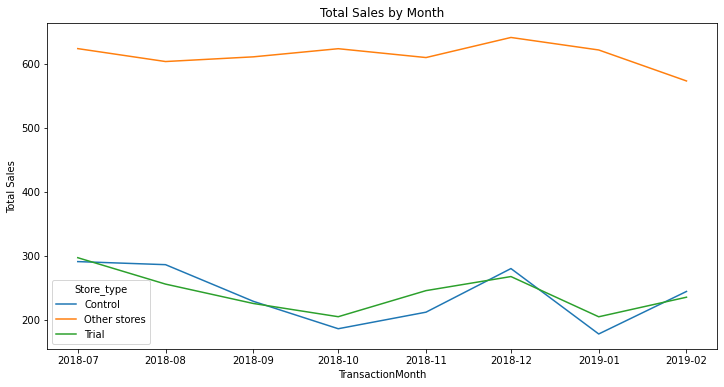

In [97]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='TOT_SALES', hue='Store_type', data = pastSales)
ax.set_title('Total Sales by Month')
ax.set_ylabel('Total Sales')

In [98]:
pastCustomers = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['MONTH_ID'], format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['MONTH_ID'] < '201903']

Text(0, 0.5, 'Number of Customers')

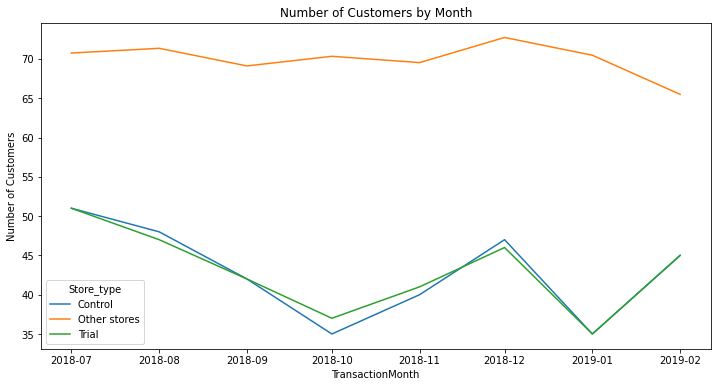

In [99]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='nCustomer', hue='Store_type', data = pastCustomers)
ax.set_title('Number of Customers by Month')
ax.set_ylabel('Number of Customers')

The trends of the mean of the customer count and total sales of both the trial store and control store are similar

## Assessment of Trial

### Total Sales

In [100]:
scalingFactorForControlSales = (rpretrial[rpretrial['STORE_NBR'] == 77]['TOT_SALES'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 233]['TOT_SALES'].sum())

In [101]:
scaledControlSales = met[met['STORE_NBR'] == 233]
scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales

C:\Users\queency\AppData\Local\Temp/ipykernel_9968/890489554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales


In [102]:
pDiff = met[met['STORE_NBR'] == 77][['STORE_NBR', 'MONTH_ID', 'TOT_SALES']].merge(
    scaledControlSales[['STORE_NBR', 'MONTH_ID', 'controlSales']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlSales'] - pDiff['TOT_SALES']) / pDiff['controlSales'])

In [103]:
pDiff

,STORE_NBR_T,MONTH_ID,TOT_SALES,STORE_NBR_C,controlSales,percentDiff
0,77,201807,296.8,233,297.565550,0.002573
1,77,201808,255.5,233,292.652187,0.126950
2,77,201809,225.2,233,233.998916,0.037602
3,77,201810,204.5,233,190.085733,0.075830
4,77,201811,245.3,233,216.597421,0.132516
5,77,201812,267.3,233,286.408121,0.066716
6,77,201901,204.4,233,181.692071,0.124980
7,77,201902,235.0,233,249.762622,0.059107
8,77,201903,278.5,233,203.802205,0.366521
9,77,201904,263.5,233,162.345704,0.623080


In [104]:
pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

In [105]:
print(stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=-1.2533353315065932e-15, pvalue=0.999999999999999)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


Our null hypothesis is of there being 0 difference between trial and control stores

In [106]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

In [107]:
pDifft

,STORE_NBR_T,MONTH_ID,TOT_SALES,STORE_NBR_C,controlSales,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,77,201902,235.0,233,249.762622,0.059107,-1.253335e-15,-0.438867,1.94318
1,77,201903,278.5,233,203.802205,0.366521,-1.253335e-15,5.716714,1.94318
2,77,201904,263.5,233,162.345704,0.623080,-1.253335e-15,10.853971,1.94318


It is observed that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store

In [108]:
ppSales = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppSales = ppSales.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

ppSales['TransactionMonth'] = pd.to_datetime(ppSales['MONTH_ID'], format='%Y%m')

ppSales_95 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_95 = ppSales_95.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppSales_5 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_5 = ppSales_5.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppSales.append([ppSales_95, ppSales_5], ignore_index=True)

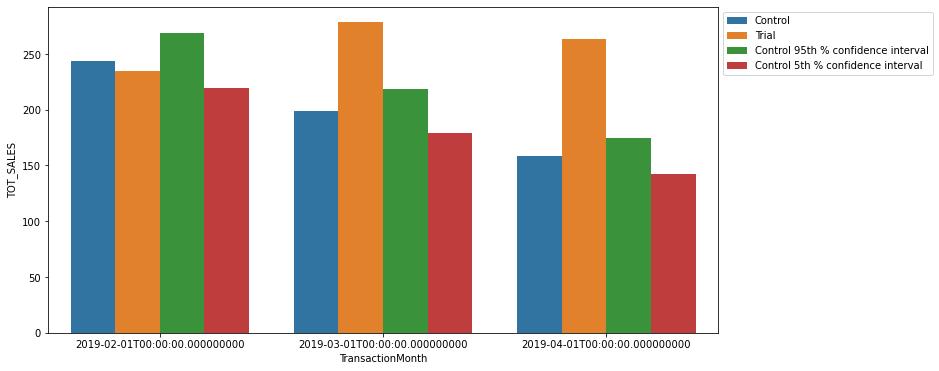

In [109]:
fig, axes = plt.subplots(figsize=(12,6))
sns.barplot(
    x='TransactionMonth',
    y='TOT_SALES',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))

plt.legend(bbox_to_anchor=(1,1))

The results show that the trial in store 77 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial 
months i.e. in the months of March and April

### Number of Customers

In [110]:
scalingFactorForControlCust = (rpretrial[rpretrial['STORE_NBR'] == 77]['nCustomer'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 233]['nCustomer'].sum())
    
scaledControlCust = met[met['STORE_NBR'] == 233]
scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust

pDiff = met[met['STORE_NBR'] == 77][['STORE_NBR', 'MONTH_ID', 'nCustomer']].merge(
    scaledControlCust[['STORE_NBR', 'MONTH_ID', 'controlCust']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlCust'] - pDiff['nCustomer']) / pDiff['controlCust'])

pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

print(stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=0.0, pvalue=1.0)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


C:\Users\queency\AppData\Local\Temp/ipykernel_9968/2901980517.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust


Our null hypothesis is of there being 0 difference between trial and control stores

In [111]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

pDifft

,STORE_NBR_T,MONTH_ID,nCustomer,STORE_NBR_C,controlCust,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,77,201902,45,233,45.151007,0.003344,0.0,-0.865091,1.94318
1,77,201903,50,233,40.134228,0.245819,0.0,12.427945,1.94318
2,77,201904,47,233,30.100671,0.561427,0.0,29.730282,1.94318


It is observed that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in customers in the trial store in March and April is statistically greater than in the control store

In [112]:
ppCust = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppCust = ppCust.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

ppCust['TransactionMonth'] = pd.to_datetime(ppCust['MONTH_ID'], format='%Y%m')

ppCust_95 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_95 = ppCust_95.assign(
    nCustomer = lambda x : x.nCustomer * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppCust_5 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_5 = ppCust_5.assign(
    nCustomer = lambda x : x.nCustomer * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppCust.append([ppCust_95, ppCust_5], ignore_index=True)

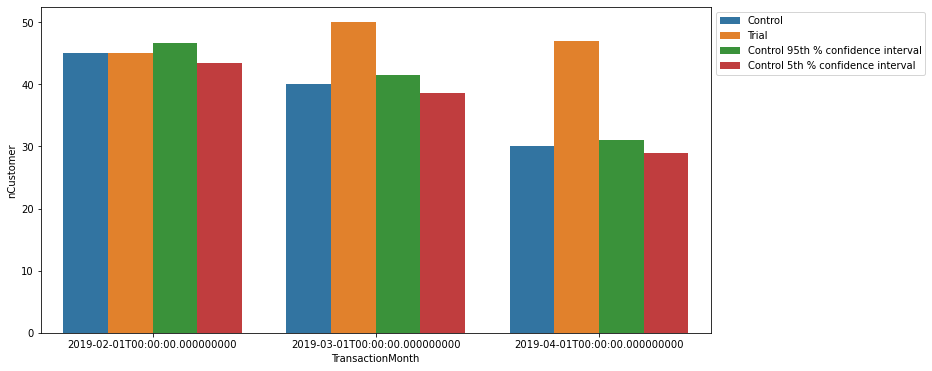

In [113]:
fig, axes = plt.subplots(figsize=(12,6))
sns.barplot(
    x='TransactionMonth',
    y='nCustomer',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))

plt.legend(bbox_to_anchor=(1,1))

And just like with total sales, the results show that the trial in store 77 is significantly different to its control store in the trial period.

# Trial Store 86

## Analysis

In [114]:
corr_nSales = calCor(rpretrial,'TOT_SALES', 86)
corr_nCustomers = calCor(rpretrial,'nCustomer', 86)

magnitude_nSales = calcMag(rpretrial, 86, 'TOT_SALES')
magnitude_nCustomer = calcMag(rpretrial, 86, 'nCustomer')

score_nSales = corr_nSales.merge(magnitude_nSales)
score_nSales = score_nSales.assign(
    score_NSales = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nSales.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

score_nCustomer = corr_nCustomers.merge(magnitude_nCustomer)
score_nCustomer = score_nCustomer.assign(
    score_NCustomer = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nCustomer.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

score_control = score_nSales.merge(score_nCustomer, on = ['Store 1', 'Store 2'])
score_control['Final_score'] = (0.5 * score_control.score_NSales) + (
    0.5 * score_control.score_NCustomer)

score_control.sort_values('Final_score', ascending=False)

C:\Users\queency\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,Store 1,Store 2,score_NSales,score_NCustomer,Final_score
80,86,86,1.000000,1.000000,1.000000
147,86,155,0.920423,0.963956,0.942190
102,86,109,0.875142,0.868359,0.871751
107,86,114,0.826848,0.895424,0.861136
130,86,138,0.841792,0.838866,0.840329
...,...,...,...,...,...
101,86,108,-0.249380,-0.176424,-0.212902
48,86,52,-0.283667,-0.276647,-0.280157
112,86,120,-0.350003,-0.219713,-0.284858
39,86,42,-0.362960,-0.312340,-0.337650


Store 155 is the closest to store 86 ans would be used as the control store

In [115]:
met['Store_type'] = met['STORE_NBR'].apply(lambda x : stype(x, 86, 155))

pastSales = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTH_ID'], format='%Y%m')
pastSales = pastSales[pastSales['MONTH_ID'] < '201903']

Text(0.5, 1.0, 'Total Sales by Month')

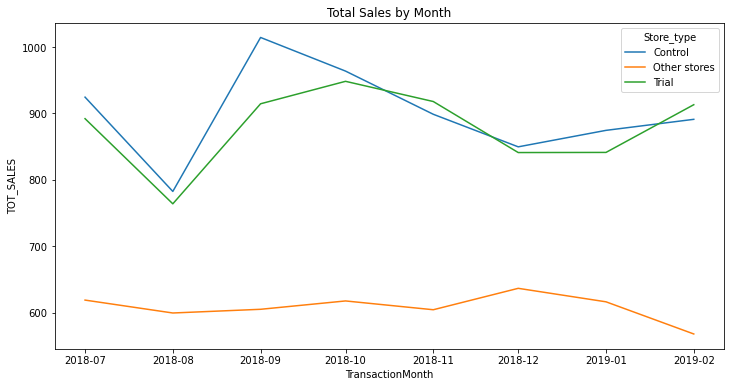

In [116]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='TOT_SALES', hue='Store_type', data = pastSales)
ax.set_title('Total Sales by Month')

In [117]:
pastCustomers = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['MONTH_ID'], format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['MONTH_ID'] < '201903']

Text(0.5, 1.0, 'Number of Customers by Month')

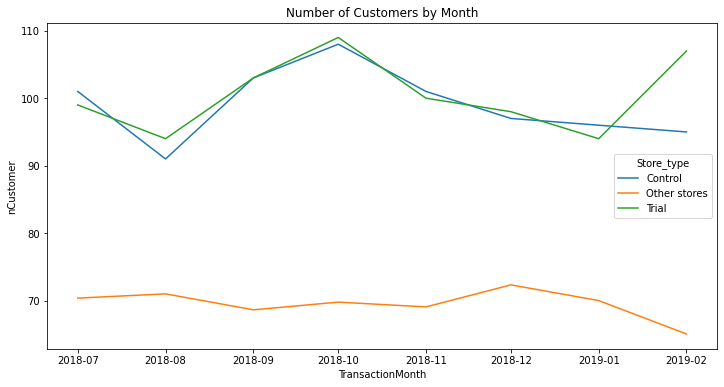

In [118]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='nCustomer', hue='Store_type', data = pastCustomers)
ax.set_title('Number of Customers by Month')

The trends are also similar

## Assessment of Trial

### Total Sales

In [119]:
scalingFactorForControlSales = (rpretrial[rpretrial['STORE_NBR'] == 86]['TOT_SALES'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 155]['TOT_SALES'].sum())

scaledControlSales = met[met['STORE_NBR'] == 155]
scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales

pDiff = met[met['STORE_NBR'] == 86][['STORE_NBR', 'MONTH_ID', 'TOT_SALES']].merge(
    scaledControlSales[['STORE_NBR', 'MONTH_ID', 'controlSales']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlSales'] - pDiff['TOT_SALES']) / pDiff['controlSales'])

C:\Users\queency\AppData\Local\Temp/ipykernel_9968/741407841.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales


In [120]:
pDiff

,STORE_NBR_T,MONTH_ID,TOT_SALES,STORE_NBR_C,controlSales,percentDiff
0,86,201807,892.20,155,896.922236,0.005265
1,86,201808,764.05,155,759.269991,0.006296
2,86,201809,914.60,155,984.034086,0.070561
3,86,201810,948.40,155,934.948790,0.014387
4,86,201811,918.00,155,871.894555,0.052880
5,86,201812,841.20,155,824.361363,0.020426
6,86,201901,841.40,155,848.418979,0.008273
7,86,201902,913.20,155,864.522060,0.056306
8,86,201903,1026.80,155,780.320405,0.315870
9,86,201904,848.20,155,819.317024,0.035253


In [121]:
pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

print(stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=3.1048311203382156e-15, pvalue=0.9999999999999976)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


Our null hypothesis is of there being 0 difference between trial and control stores

In [122]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

pDifft

,STORE_NBR_T,MONTH_ID,TOT_SALES,STORE_NBR_C,controlSales,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,86,201902,913.2,155,864.522060,0.056306,3.104831e-15,1.194752,1.94318
1,86,201903,1026.8,155,780.320405,0.315870,3.104831e-15,11.242132,1.94318
2,86,201904,848.2,155,819.317024,0.035253,3.104831e-15,0.379790,1.94318


It is observed that the t-value is smaller than the 95th percentile value of the t-distribution for February and April - i.e. the increase in sales in the trial store in February and April is not statistically greater than in the control store

In [123]:
ppSales = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppSales = ppSales.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

ppSales['TransactionMonth'] = pd.to_datetime(ppSales['MONTH_ID'], format='%Y%m')

ppSales_95 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_95 = ppSales_95.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppSales_5 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_5 = ppSales_5.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppSales.append([ppSales_95, ppSales_5], ignore_index=True)

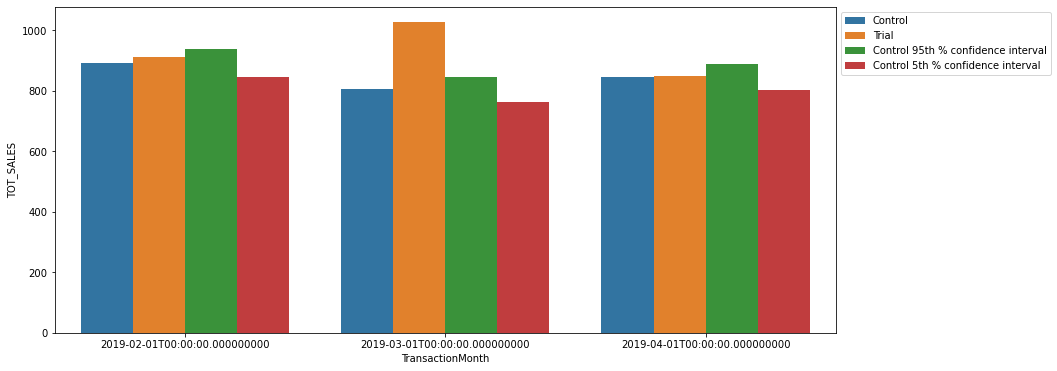

In [124]:
fig, axes = plt.subplots(figsize=(14,6))
sns.barplot(
    x='TransactionMonth',
    y='TOT_SALES',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))
plt.legend(bbox_to_anchor=(1,1))

The results show that the trial in store 86 is significantly not different to its control store in the trial period as the trial store performance lies inside the 5% to 95% confidence interval of the control store in two of the three trial months i.e. in the months of February and April

### Number of Customers

In [125]:
scalingFactorForControlCust = (rpretrial[rpretrial['STORE_NBR'] == 86]['nCustomer'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 155]['nCustomer'].sum())
    
scaledControlCust = met[met['STORE_NBR'] == 155]
scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust

pDiff = met[met['STORE_NBR'] == 86][['STORE_NBR', 'MONTH_ID', 'nCustomer']].merge(
    scaledControlCust[['STORE_NBR', 'MONTH_ID', 'controlCust']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlCust'] - pDiff['nCustomer']) / pDiff['controlCust'])

pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

print(stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=0.0, pvalue=1.0)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


C:\Users\queency\AppData\Local\Temp/ipykernel_9968/806158278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust


Our null hypothesis is of there being 0 difference between trial and control stores

In [126]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

pDifft

,STORE_NBR_T,MONTH_ID,nCustomer,STORE_NBR_C,controlCust,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,86,201902,107,155,95.0,0.126316,0.0,10.441339,1.94318
1,86,201903,115,155,94.0,0.223404,0.0,19.525687,1.94318
2,86,201904,105,155,99.0,0.060606,0.0,4.293029,1.94318


It is observed that the t-value is much larger than the 95th percentile value of the t-distribution for all the months - i.e. the increase in customers in the trial store in the trial period is statistically greater than in the control store

In [127]:
ppCust = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppCust = ppCust.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

ppCust['TransactionMonth'] = pd.to_datetime(ppCust['MONTH_ID'], format='%Y%m')

ppCust_95 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_95 = ppCust_95.assign(
    nCustomer = lambda x : x.nCustomer * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppCust_5 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_5 = ppCust_5.assign(
    nCustomer = lambda x : x.nCustomer * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppCust.append([ppCust_95, ppCust_5], ignore_index=True)

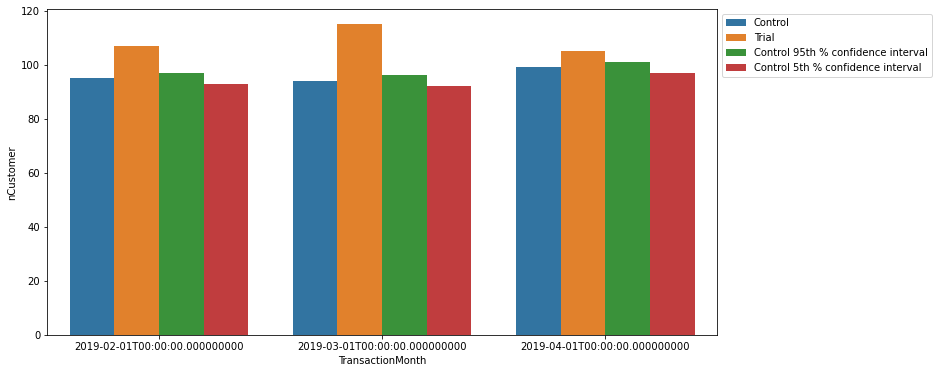

In [128]:
fig, axes = plt.subplots(figsize=(12,6))
sns.barplot(
    x='TransactionMonth',
    y='nCustomer',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))

plt.legend(bbox_to_anchor=(1,1))

It looks like the number of customers is significantly higher in all of the three months. This seems to suggest that the trial had a significant impact on increasing
the number of customers in trial store 86 but as we saw, sales were not significantly higher

# Trial Store 88

## Analysis

In [129]:
corr_nSales = calCor(rpretrial,'TOT_SALES', 88)
corr_nCustomers = calCor(rpretrial,'nCustomer', 88)

magnitude_nSales = calcMag(rpretrial, 88, 'TOT_SALES')
magnitude_nCustomer = calcMag(rpretrial, 88, 'nCustomer')

score_nSales = corr_nSales.merge(magnitude_nSales)
score_nSales = score_nSales.assign(
    score_NSales = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nSales.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

score_nCustomer = corr_nCustomers.merge(magnitude_nCustomer)
score_nCustomer = score_nCustomer.assign(
    score_NCustomer = lambda x : (0.5 * x.corrMeasure) + (0.5 * x.magnitudeMeasure))
score_nCustomer.drop(columns = ['corrMeasure', 'magnitudeMeasure'], inplace = True)

score_control = score_nSales.merge(score_nCustomer, on = ['Store 1', 'Store 2'])
score_control['Final_score'] = (0.5 * score_control.score_NSales) + (
    0.5 * score_control.score_NCustomer)

score_control.sort_values('Final_score', ascending=False)

C:\Users\queency\anaconda3\lib\site-packages\pandas\core\frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


,Store 1,Store 2,score_NSales,score_NCustomer,Final_score
82,88,88,1.000000,1.000000,1.000000
225,88,237,0.632277,0.967456,0.799867
170,88,178,0.713855,0.880310,0.797083
65,88,69,0.578920,0.842388,0.710654
106,88,113,0.589285,0.823346,0.706315
...,...,...,...,...,...
84,88,90,-0.240296,-0.090374,-0.165335
245,88,258,0.051069,-0.404039,-0.176485
133,88,141,-0.244703,-0.123792,-0.184248
227,88,239,-0.194453,-0.178185,-0.186319


It is observed that store 237 is closest in terms of scores to store 88. Hence it'd be used as the control store for store 88

In [130]:
met['Store_type'] = met['STORE_NBR'].apply(lambda x : stype(x, 88, 237))

pastSales = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

pastSales['TransactionMonth'] = pd.to_datetime(pastSales['MONTH_ID'], format='%Y%m')
pastSales = pastSales[pastSales['MONTH_ID'] < '201903']

Text(0.5, 1.0, 'Total Sales by Month')

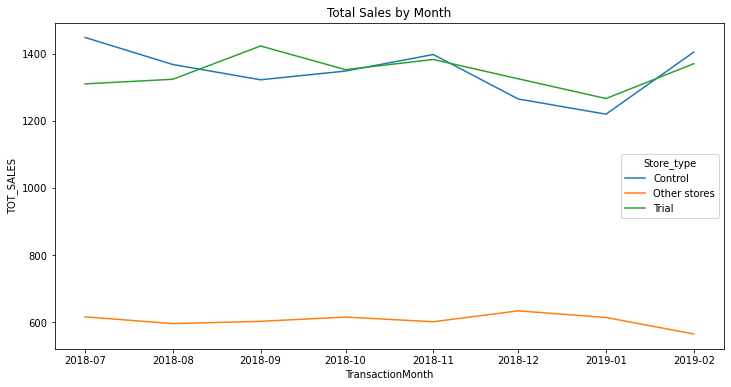

In [131]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='TOT_SALES', hue='Store_type', data = pastSales)
ax.set_title('Total Sales by Month')

In [132]:
pastCustomers = met.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

pastCustomers['TransactionMonth'] = pd.to_datetime(pastCustomers['MONTH_ID'], format='%Y%m')
pastCustomers = pastCustomers[pastCustomers['MONTH_ID'] < '201903']

Text(0.5, 1.0, 'Number of Customers by Month')

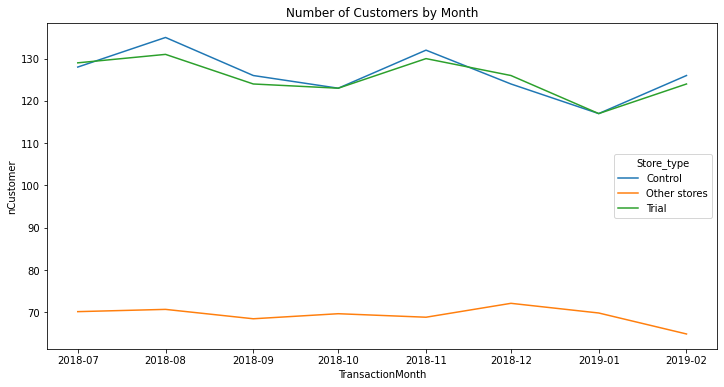

In [133]:
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(x='TransactionMonth', y='nCustomer', hue='Store_type', data = pastCustomers)
ax.set_title('Number of Customers by Month')

### Assessment of Trial

In [134]:
scalingFactorForControlSales = (rpretrial[rpretrial['STORE_NBR'] == 88]['TOT_SALES'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 237]['TOT_SALES'].sum())

scaledControlSales = met[met['STORE_NBR'] == 237]
scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales

pDiff = met[met['STORE_NBR'] == 88][['STORE_NBR', 'MONTH_ID', 'TOT_SALES']].merge(
    scaledControlSales[['STORE_NBR', 'MONTH_ID', 'controlSales']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlSales'] - pDiff['TOT_SALES']) / pDiff['controlSales'])

C:\Users\queency\AppData\Local\Temp/ipykernel_9968/1522013055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlSales['controlSales'] = scaledControlSales.loc[:,'TOT_SALES'] * scalingFactorForControlSales


In [135]:
pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

print(stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=6.4562888442484815e-15, pvalue=0.999999999999995)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


Our null hypothesis is of there being 0 difference between trial and control stores

In [136]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['TOT_SALES'],
               pDiffp['controlSales']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

pDifft

,STORE_NBR_T,MONTH_ID,TOT_SALES,STORE_NBR_C,controlSales,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,88,201902,1370.2,237,1406.989143,0.026147,6.456289e-15,-0.505415,1.94318
1,88,201903,1477.2,237,1210.082775,0.220743,6.456289e-15,5.308983,1.94318
2,88,201904,1439.4,237,1206.477165,0.193060,6.456289e-15,4.481842,1.94318


It is observed that the t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the control store

In [137]:
ppSales = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppSales = ppSales.groupby(['MONTH_ID', 'Store_type']).agg({
    'TOT_SALES':'mean'
}).reset_index()

ppSales['TransactionMonth'] = pd.to_datetime(ppSales['MONTH_ID'], format='%Y%m')

ppSales_95 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_95 = ppSales_95.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppSales_5 = ppSales[ppSales['Store_type'] == 'Control']
ppSales_5 = ppSales_5.assign(
    TOT_SALES = lambda x : x.TOT_SALES * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppSales.append([ppSales_95, ppSales_5], ignore_index=True)

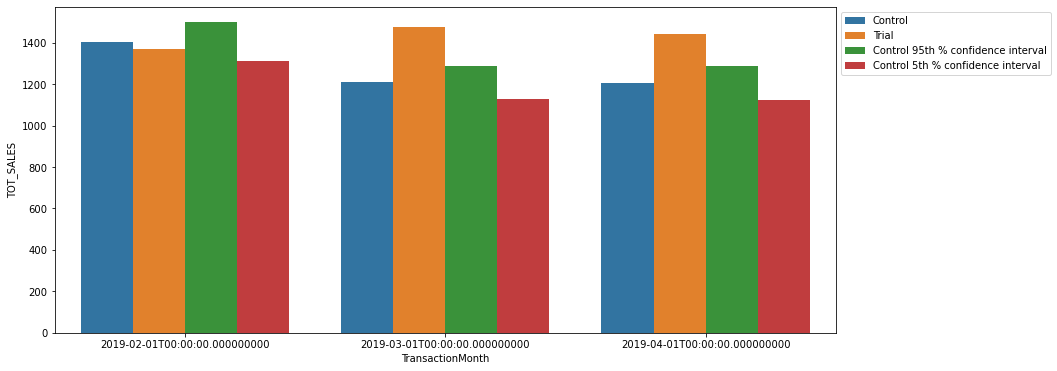

In [138]:
fig, axes = plt.subplots(figsize=(14,6))
sns.barplot(
    x='TransactionMonth',
    y='TOT_SALES',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))
plt.legend(bbox_to_anchor=(1,1))

The results show that the trial in store 88 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months i.e. in the months of March and April

In [139]:
scalingFactorForControlCust = (rpretrial[rpretrial['STORE_NBR'] == 88]['nCustomer'].sum())/(
    rpretrial[rpretrial['STORE_NBR'] == 237]['nCustomer'].sum())
    
scaledControlCust = met[met['STORE_NBR'] == 237]
scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust

pDiff = met[met['STORE_NBR'] == 88][['STORE_NBR', 'MONTH_ID', 'nCustomer']].merge(
    scaledControlCust[['STORE_NBR', 'MONTH_ID', 'controlCust']], on='MONTH_ID', suffixes=('_T', '_C'))

pDiff['percentDiff'] = abs((pDiff['controlCust'] - pDiff['nCustomer']) / pDiff['controlCust'])

pDiffp = pDiff[pDiff['MONTH_ID']<'201902'].reset_index(drop=True)
pDifft = pDiff[(pDiff['MONTH_ID']>'201901') & (pDiff['MONTH_ID']<'201905')].reset_index(drop=True)

stdDev = (pDiffp['percentDiff']).std()

print(stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']))
print()
print('Critical t value for 95% confidence value')
alpha = 0.05
print(stats.t.ppf((alpha/2, 1-alpha/2), df= len(pDiffp)-1))

Ttest_indResult(statistic=0.0, pvalue=1.0)

Critical t value for 95% confidence value
[-2.44691185  2.44691185]


C:\Users\queency\AppData\Local\Temp/ipykernel_9968/2698178639.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaledControlCust['controlCust'] = scaledControlCust.loc[:,'nCustomer'] * scalingFactorForControlCust


Our null hypothesis is of there being 0 difference between trial and control stores

In [140]:
pDifft['t_value'] = stats.ttest_ind(pDiffp['nCustomer'],
               pDiffp['controlCust']).statistic
pDifft['test_stat'] = pDifft['percentDiff'].apply(lambda x : (x-pDiffp['percentDiff'].mean())/ pDiffp['percentDiff'].std())
pDifft['95th Percentile of t-distribution'] = stats.t.ppf(0.95, df=len(pDiffp)-1)

pDifft

,STORE_NBR_T,MONTH_ID,nCustomer,STORE_NBR_C,controlCust,percentDiff,t_value,test_stat,95th Percentile of t-distribution
0,88,201902,124,237,125.288136,0.010281,0.0,-0.362210,1.94318
1,88,201903,134,237,118.327684,0.132448,0.0,16.124027,1.94318
2,88,201904,128,237,119.322034,0.072727,0.0,8.064757,1.94318


The t-value is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in customers in the trial store in March and April is statistically greater than in the control store

In [141]:
ppCust = met[(met['Store_type'] =='Trial') | (met['Store_type'] =='Control')].reset_index(drop=True)
ppCust = ppCust.groupby(['MONTH_ID', 'Store_type']).agg({
    'nCustomer':'mean'
}).reset_index()

ppCust['TransactionMonth'] = pd.to_datetime(ppCust['MONTH_ID'], format='%Y%m')

ppCust_95 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_95 = ppCust_95.assign(
    nCustomer = lambda x : x.nCustomer * (1 + stdDev * 2),
    Store_type = 'Control 95th % confidence interval').reset_index(drop=True)

ppCust_5 = ppCust[ppCust['Store_type'] == 'Control']
ppCust_5 = ppCust_5.assign(
    nCustomer = lambda x : x.nCustomer * (1 - stdDev * 2),
    Store_type = 'Control 5th % confidence interval').reset_index(drop=True)

trialAssessment = ppCust.append([ppCust_95, ppCust_5], ignore_index=True)

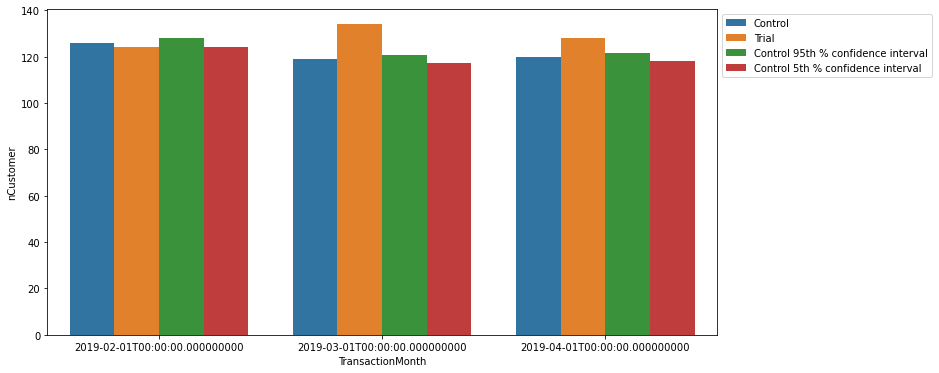

In [142]:
fig, axes = plt.subplots(figsize=(12,6))
sns.barplot(
    x='TransactionMonth',
    y='nCustomer',
    hue='Store_type',
    data=trialAssessment[(trialAssessment['MONTH_ID']>'201901') & (
        trialAssessment['MONTH_ID']<'201905')].reset_index(drop=True))

plt.legend(bbox_to_anchor=(1,1))

Total number of customers in the trial period for the trial store is significantly 
higher than the control store for two out of three months, which indicates a positive trial effect

# Conclusion

Control stores 233, 155, 237 for trial stores 77, 86 and 88 respectively.
The results for trial stores 77 and 88 during the trial period show a significant 
difference in at least two of the three trial months but this is not the case for 
trial store 86. We can check with the client if the implementation of the trial was
different in trial store 86 but overall, the trial shows a significant increase in 
sales